# Isolating Context

*Isolating context involves splitting it up to help an agent perform a task.*

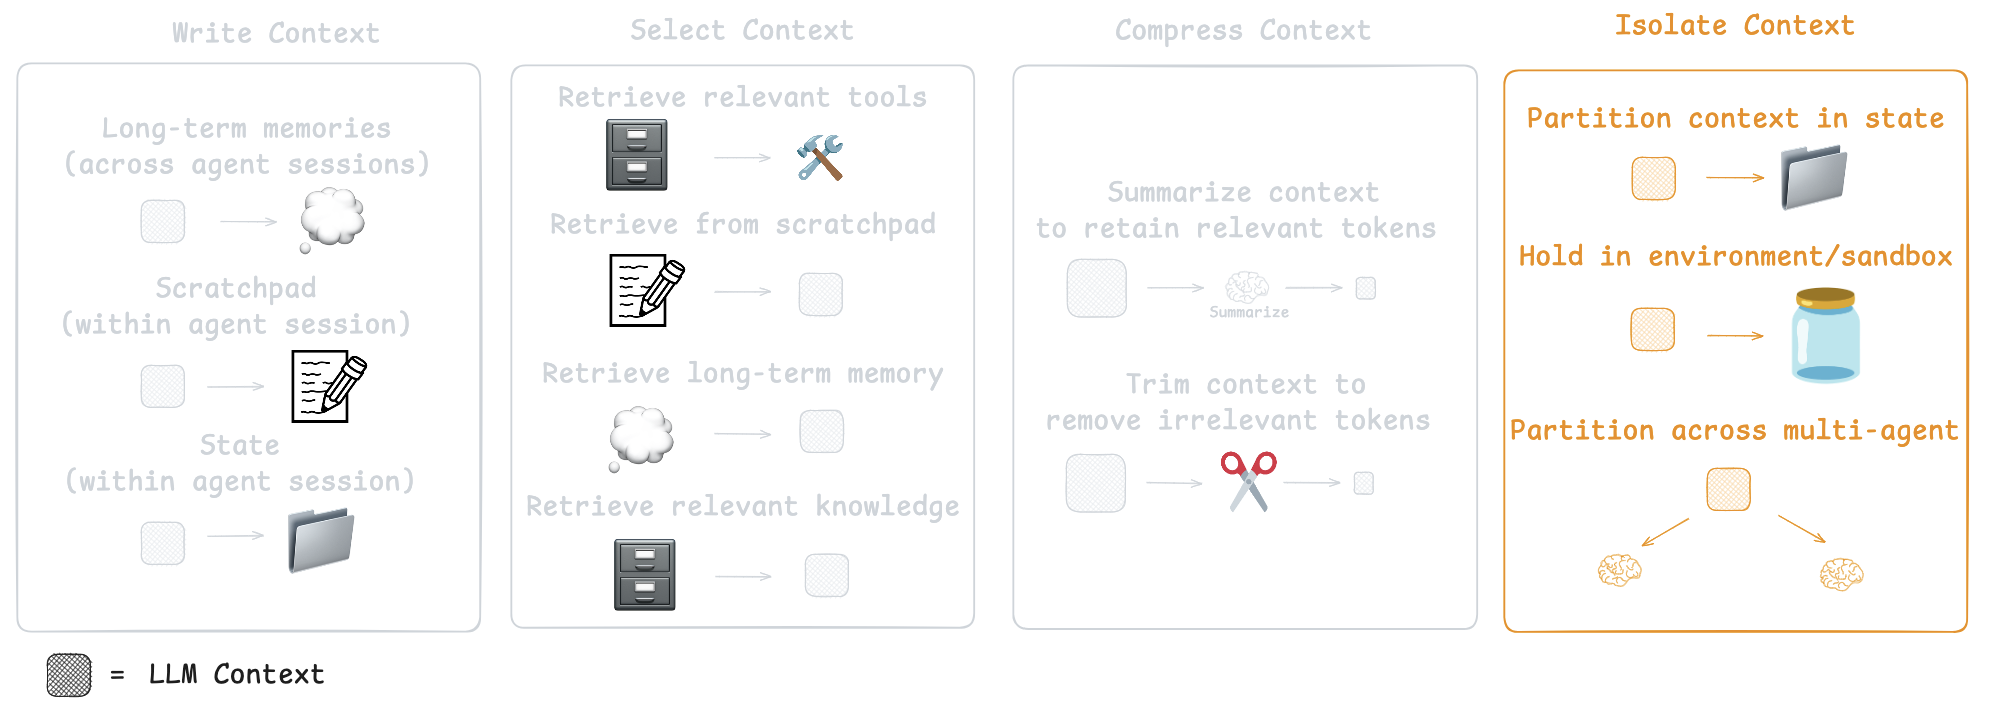

## Multi-Agent

One of the most popular and intuitive ways to isolate context is to split it across sub-agents. A motivation for the OpenAI [Swarm](https://github.com/openai/swarm) library was “[separation of concerns](https://openai.github.io/openai-agents-python/ref/agent/)”, where a team of agents can handle sub-tasks. Each agent has a specific set of tools, instructions, and its own context window.

Anthropic’s [multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) makes a clear case for the benefit of this: many agents with isolated contexts outperformed single-agent by 90.2%, largely because each subagent context window can be allocated to a more narrow sub-task. As the blog said:

> [Subagents operate] in parallel with their own context windows, exploring different aspects of the question simultaneously. 

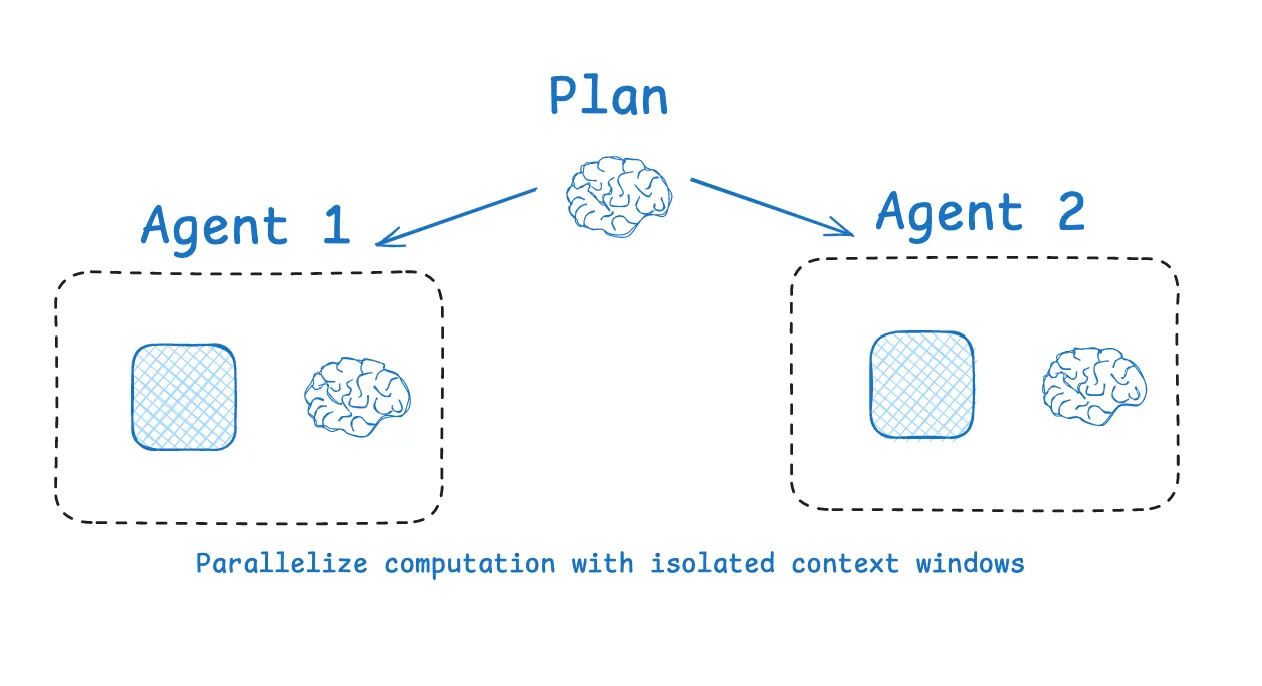

Of course, the challenge with multi-agent include token use (e.g., [15× more tokens](https://www.anthropic.com/engineering/built-multi-agent-research-system) than chat), the need for careful [prompt engineering](https://www.anthropic.com/engineering/built-multi-agent-research-system) to plan sub-agent work, and coordination of sub-agents.

### Multi-Agent in LangGraph

LangGraph supports multi-agent systems. A popular and intuitive way to implement this is the [supervisor](https://github.com/langchain-ai/langgraph-supervisor-py) architecture, which is what is used in Anthropic's [multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system). This allows the supervisor to delegate tasks to sub-agents, each with their own context window.

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

# Initialize the language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)


def add(a: float, b: float) -> float:
    """Add two numbers.
    
    Args:
        a: First number
        b: Second number
        
    Returns:
        Sum of a and b
    """
    return a + b


def multiply(a: float, b: float) -> float:
    """Multiply two numbers.
    
    Args:
        a: First number
        b: Second number
        
    Returns:
        Product of a and b
    """
    return a * b


def web_search(query: str) -> str:
    """Mock web search function that returns FAANG company headcounts.
    
    Args:
        query: Search query (unused in this mock)
        
    Returns:
        Static information about FAANG company headcounts
    """
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )


# Create specialized agents with isolated contexts
math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow for coordinating agents
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile the multi-agent application
app = workflow.compile()

# Execute the multi-agent workflow
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the combined headcount of the FAANG companies in 2024?"
        }
    ]
})

In [3]:
from utils import format_messages
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what's the combined headcount of the FAANG companies in 2024?                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find the combined headcount of the FAANG companies (Facebook/Meta, Apple, Amazon, Netflix,        │
│ Google/Alphabet) for 2024. This requires researching current employment data for these major tech companies.    │
│                                                                                                                 │
│ 🔧 Tool Call: transfer_to_research_expert                                                                       │
│    Args: {}                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to research_expert                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research, here are the 2024 employee headcounts for the FAANG companies:                            │
│                                                                                                                 │
│ **Individual Company Headcounts (2024):**                                                                       │
│ - **Meta (Facebook)**: 67,317 employees                                                                         │
│ - **Apple**: 164,000 employees                                                                                  │
│ - **Amazon**: 1,551,000 employees                                                                               │
│ - **Netflix**: 14,000 employees                                                                                 │
│ - **Google (Alphabet)**: 181,269 employees                                                                      │
│                                                                                                                 │
│ **Combined FAANG Headcount**: 1,977,586 employees                                                               │
│                                                                                                                 │
│ Amazon represents by far the largest portion of this total workforce, accounting for approximately 78% of the   │
│ combined FAANG headcount. This is largely due to Amazon's massive logistics, warehousing, and retail operations │
│ that require significant physical workforce beyond just tech roles.                                             │
│                                                                                                                 │
│ It's worth noting that these numbers represent the most recent available data for 2024, and employee counts at  │
│ these companies can fluctuate due to hiring, layoffs, and business changes throughout the year.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Learn more

* **LangGraph Swarm** - https://github.com/langchain-ai/langgraph-swarm-py

LangGraph Swarm is a Python library for creating multi-agent AI systems with dynamic collaboration capabilities. Key features include agents that can dynamically hand off control based on specialization while maintaining conversation context between transitions. The library supports customizable handoff tools between agents, streaming, short-term and long-term memory, and human-in-the-loop interactions. Built on the LangGraph framework, it enables creating flexible, context-aware multi-agent systems where different AI agents can collaborate and seamlessly transfer conversation control based on their unique capabilities. Installation is simple with `pip install langgraph-swarm`.

* [See](https://www.youtube.com/watch?v=4nZl32FwU-o) [these](https://www.youtube.com/watch?v=JeyDrn1dSUQ) [videos](https://www.youtube.com/watch?v=B_0TNuYi56w) for more detail on on multi-agent systems.

## Sandboxed Environment

HuggingFace’s [deep researcher](https://huggingface.co/blog/open-deep-research#:~:text=From%20building%20,it%20can%20still%20use%20it) shows another interesting example of context isolation. Most agents use [tool calling APIs](https://docs.anthropic.com/en/docs/agents-and-tools/tool-use/overview), which return JSON objects (tool arguments) that can be passed to tools (e.g., a search API) to get tool feedback (e.g., search results). HuggingFace uses a [CodeAgent](https://huggingface.co/papers/2402.01030), which outputs code to invoke tools. The code then runs in a [sandbox](https://e2b.dev/). Selected context (e.g., return values) from code execution is then passed back to the LLM.

This allows context to be isolated in the environment, outside of the LLM context window. Hugging Face noted that this is a great way to isolate token-heavy objects from the LLM:

> [Code Agents allow for] a better handling of state … Need to store this image / audio / other for later use? No problem, just assign it as a variable in your state and you [use it later].

### Sandboxed Environment in LangGraph

It's pretty easy to use Sandboxes with LangGraph agents. [LangChain Sandbox](https://github.com/langchain-ai/langchain-sandbox) provides a secure environment for executing untrusted Python code. It leverages Pyodide (Python compiled to WebAssembly) to run Python code in a sandboxed environment. This can simply be used as a tool in a LangGraph agent.

> NOTE: Install Deno (required): https://docs.deno.com/runtime/getting_started/installation/

In [4]:
from langchain_sandbox import PyodideSandboxTool
tool = PyodideSandboxTool()
result = await tool.ainvoke("print('Hello, world!')")

In [ ]:
from langchain_sandbox import PyodideSandboxTool
from langgraph.prebuilt import create_react_agent

# Create sandbox tool with network access for package installation
tool = PyodideSandboxTool(
    # Allow Pyodide to install Python packages that might be required
    allow_net=True
)

# Create a React agent with the sandbox tool
agent = create_react_agent(
    "anthropic:claude-3-7-sonnet-latest",
    tools=[tool],
)

# Execute a mathematical query using the sandbox
result = await agent.ainvoke(
    {"messages": [{"role": "user", "content": "what's 5 + 7?"}]},
)

# Format and display the results
format_messages(result['messages'])

### State 

An agent’s runtime state object can also be a great way to isolate context. This can serve the same purpose as sandboxing. A state object can be designed with a schema (e.g., a Pydantic model) that has various fields that context can be written to. One field of the schema (e.g., messages) can be exposed to the LLM at each turn of the agent, but the schema can isolate information in other fields for more selective use. 

### State Isolation in LangGraph

LangGraph is designed around a [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) object, allowing you to design a state schema and access different fields of that schema across trajectory of your agent. For example, you can easily store context from tool calls in certain fields of your state object, isolating from the LLM until that context is required. In these notebooks, you've seen numerous example of this.
